In [1]:
from platform import python_version
python_version()

'3.6.12'

In [2]:
import time
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, log_loss

In [3]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
tf.__version__

'1.15.0'

## functions

In [6]:
#List of metric for classiffication models

def metrics_classific(y,predicted,X):
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
    confusion_matrix = confusion_matrix(y, predicted)
    print(confusion_matrix)
    print(classification_report(y, predicted))

    # Validation ROC-AUC score
    from sklearn.metrics import roc_auc_score
    valid_score = roc_auc_score(y, predicted)
    print('Validation ROC-AUC score:', valid_score)

    # AUC score
    from sklearn.metrics import  auc
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, predicted)
    auc = auc(false_positive_rate, true_positive_rate)
    print('Validation AUC score:    ', auc)
    print("Accuracy: %.2f%%" % (accuracy_score(y, predicted) * 100.0))

In [7]:
def sigmoid(z):
    return 1/(1.0 + np.exp(-z))

In [8]:
#transform prob_prediction to predictions
def predictor(prob_prediction):
    return np.array(([propability[0] < propability[1] for propability in prob_prediction]), dtype=int)

# Import dataset

In [9]:
X_true = pd.read_csv('X_true.csv').values
y_true = pd.read_csv('y_true.csv').values

In [10]:
X_true.shape, y_true.shape

((10800, 12288), (10800, 1))

In [11]:
from sklearn.model_selection import train_test_split
seed = 78
test_size = 0.33
X_train, X_, y_train, y_ = train_test_split(X_true, y_true, test_size=test_size, random_state=seed)
X_test, X_validate, y_test, y_validate = train_test_split(X_, y_, test_size=test_size, random_state=seed)

# MultiLayer Perceptron (MLP)

In [12]:
shape = y_train.shape
y_orig = y_train.reshape(shape[0],1)

from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
oneHot.fit(y_orig) 
data_y = oneHot.transform(y_orig).toarray()

In [13]:
shape = y_test.shape
y_test_orig = y_test.reshape(shape[0],1)

from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
oneHot.fit(y_test_orig) 
test_y = oneHot.transform(y_test_orig).toarray() 

In [14]:
data_x = X_train 
data_x.shape, data_y.shape

((7236, 12288), (7236, 2))

In [15]:
hidden_layer_nodes = 5
learning_rate = 0.01
L2 =0.001 #regulization
n_epochs = 9000

num_features =data_x.shape[1]
num_classes = data_y.shape[1]

X_hold = tf.placeholder(tf.float32, [None, num_features]) 
Y_hold = tf.placeholder(tf.float32, [None,num_classes])

#Hidden layer
W1 = tf.Variable(tf.truncated_normal([num_features, hidden_layer_nodes], stddev=0.1))
W1
b1 = tf.Variable(tf.constant(0.1, shape=[hidden_layer_nodes]))
z1 = tf.add(tf.matmul(X_hold,W1),b1)
#a1 = tf.nn.leaky_relu(z1)               #activization function LeakyRelu
a1 = tf.nn.relu(z1)                    ##activization function Relu

#Dropout Layer
keep_prob = tf.placeholder(tf.float32)
a_drop = tf.nn.dropout(a1, keep_prob)

#Output Layer
W2 = tf.Variable(tf.truncated_normal([hidden_layer_nodes,num_classes], stddev=0.1)) 
b2 = tf.Variable(tf.constant(0.1, shape=[num_classes]))
z2 = tf.matmul(a_drop,W2) + b2
logit = tf.sigmoid(z2) #activization function sigmoid

#cost function/cross_entropy
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_hold, logits=logit) + L2*tf.nn.l2_loss(W1)+ L2*tf.nn.l2_loss(W2))
#train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss) # Adam 
train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss) #Gradient Descent


train_acc = []
test_acc = []
losses = []
aucs = []
# Define the accuracy
prediction = tf.round(logit)
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, Y_hold), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Initial session

In [16]:
%%time
##Initial session
saver = tf.train.Saver()
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    #save initial weights
    Initial_MLP_W1 = sess.run(W1)
    Initial_MLP_W2 = sess.run(W2)
    
    # Gradient descent
    for i in range(n_epochs):
        _, iloss, y_hat, temp_train_acc = sess.run([train_step, loss, prediction, accuracy], {X_hold:data_x, Y_hold:data_y,keep_prob : 1.0})
        temp_test_acc = sess.run(accuracy, feed_dict={X_hold:X_test, Y_hold:test_y,keep_prob : 1.0}) 
        if i%100==0:
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            losses.append(iloss)
            aucs.append(roc_auc_score(data_y, y_hat))
        if i%100==0:
            print('%i th Epoch Train AUC: %.4f Loss: %.4f' % (i, roc_auc_score(data_y, y_hat), iloss))
    
    multi_prob_predictions = sess.run(z2, feed_dict={X_hold:X_test, keep_prob : 1.0})
    W1_matrix = sess.run(W1)
    W2_matrix = sess.run(W2)
    b1_vector = sess.run(b1)
    b2_vector = sess.run(b2)
    saver.save(sess, 'MLP_0')

0 th Epoch Train AUC: 0.4901 Loss: 1.0078
100 th Epoch Train AUC: 0.5142 Loss: 0.9342
200 th Epoch Train AUC: 0.5188 Loss: 0.9313
300 th Epoch Train AUC: 0.5223 Loss: 0.9289
400 th Epoch Train AUC: 0.5250 Loss: 0.9271
500 th Epoch Train AUC: 0.5266 Loss: 0.9260
600 th Epoch Train AUC: 0.5286 Loss: 0.9246
700 th Epoch Train AUC: 0.5287 Loss: 0.9241
800 th Epoch Train AUC: 0.5313 Loss: 0.9222
900 th Epoch Train AUC: 0.5323 Loss: 0.9213
1000 th Epoch Train AUC: 0.5326 Loss: 0.9207
1100 th Epoch Train AUC: 0.5327 Loss: 0.9201
1200 th Epoch Train AUC: 0.5330 Loss: 0.9195
1300 th Epoch Train AUC: 0.5334 Loss: 0.9189
1400 th Epoch Train AUC: 0.5339 Loss: 0.9181
1500 th Epoch Train AUC: 0.5342 Loss: 0.9175
1600 th Epoch Train AUC: 0.5348 Loss: 0.9168
1700 th Epoch Train AUC: 0.5352 Loss: 0.9162
1800 th Epoch Train AUC: 0.5355 Loss: 0.9155
1900 th Epoch Train AUC: 0.5361 Loss: 0.9149
2000 th Epoch Train AUC: 0.5354 Loss: 0.9146
2100 th Epoch Train AUC: 0.5373 Loss: 0.9134
2200 th Epoch Train AU

In [18]:
tensor_predictions = predictor(multi_prob_predictions)
metrics_classific(y_test,tensor_predictions, X_test)

[[ 301  767]
 [ 213 1106]]
              precision    recall  f1-score   support

         0.0       0.59      0.28      0.38      1068
         1.0       0.59      0.84      0.69      1319

    accuracy                           0.59      2387
   macro avg       0.59      0.56      0.54      2387
weighted avg       0.59      0.59      0.55      2387

Validation ROC-AUC score: 0.5601746158848067
Validation AUC score:     0.5601746158848067
Accuracy: 58.94%


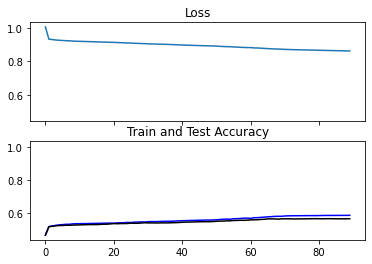

In [20]:
fig, ((ax1),(ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
        
ax1.plot(range(n_epochs//100), losses)
ax1.title.set_text('Loss') 
        
# accuracy
ax2.plot(train_acc, 'b-', label='train accuracy')
ax2.plot(test_acc, 'k-', label='test accuracy')
ax2.title.set_text('Train and Test Accuracy')
plt.show() 

## Save model

In [21]:
#Save model
from numpy import loadtxt
np.savetxt('Initial_MLP_W1.csv', Initial_MLP_W1, delimiter=',')
np.savetxt('Initial_MLP_W2.csv', Initial_MLP_W2, delimiter=',')

np.savetxt('W1_matrix.csv', W1_matrix, delimiter=',')
np.savetxt('W2_matrix.csv', W2_matrix, delimiter=',')

np.savetxt('b1_vector.csv', b1_vector, delimiter=',')
np.savetxt('b2_vector.csv', b2_vector, delimiter=',') 

## restored session 1

In [22]:
model_name = 'MLP_0.meta'
num_features =data_x.shape[1]
num_classes = data_y.shape[1]

In [23]:
learning_rate = 0.01
L2 =0.001 #regulization
n_epochs = 15000

In [24]:
Initial_MLP_W1 = pd.read_csv('Initial_MLP_W1.csv',header=None).values
Initial_MLP_W2 = pd.read_csv('Initial_MLP_W2.csv',header=None).values
W1 = pd.read_csv('W1_matrix.csv',header=None).values
W2 = pd.read_csv('W2_matrix.csv',header=None).values
b1 = pd.read_csv('b1_vector.csv',header=None).values
b2 = pd.read_csv('b2_vector.csv',header=None).values

In [25]:
%%time
##restored session
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(model_name)
    sess.run(tf.global_variables_initializer())
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
    
    # Gradient descent
    for i in range(n_epochs):
        _, iloss, y_hat, temp_train_acc = sess.run([train_step, loss, prediction, accuracy], {X_hold:data_x, Y_hold:data_y,keep_prob : 1.0})
        temp_test_acc = sess.run(accuracy, feed_dict={X_hold:X_test, Y_hold:test_y,keep_prob : 1.0}) 
        if i%100==0:
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            losses.append(iloss)
            aucs.append(roc_auc_score(data_y, y_hat))
        if i%100==0:
            print('%i th Epoch Train AUC: %.4f Loss: %.4f' % (i, roc_auc_score(data_y, y_hat), iloss))
    
    multi_prob_predictions = sess.run(z2, feed_dict={X_hold:X_test, keep_prob : 1.0})
    W1_matrix = sess.run(W1)
    W2_matrix = sess.run(W2)
    b1_vector = sess.run(b1)
    b2_vector = sess.run(b2)
    saver.save(sess, 'MLP_1')

INFO:tensorflow:Restoring parameters from ./MLP_0
0 th Epoch Train AUC: 0.5849 Loss: 0.8624
100 th Epoch Train AUC: 0.5850 Loss: 0.8620
200 th Epoch Train AUC: 0.5852 Loss: 0.8615
300 th Epoch Train AUC: 0.5853 Loss: 0.8611
400 th Epoch Train AUC: 0.5853 Loss: 0.8606
500 th Epoch Train AUC: 0.5854 Loss: 0.8602
600 th Epoch Train AUC: 0.5854 Loss: 0.8598
700 th Epoch Train AUC: 0.5854 Loss: 0.8594
800 th Epoch Train AUC: 0.5855 Loss: 0.8590
900 th Epoch Train AUC: 0.5856 Loss: 0.8585
1000 th Epoch Train AUC: 0.5856 Loss: 0.8581
1100 th Epoch Train AUC: 0.5856 Loss: 0.8577
1200 th Epoch Train AUC: 0.5856 Loss: 0.8574
1300 th Epoch Train AUC: 0.5856 Loss: 0.8570
1400 th Epoch Train AUC: 0.5856 Loss: 0.8566
1500 th Epoch Train AUC: 0.5858 Loss: 0.8561
1600 th Epoch Train AUC: 0.5859 Loss: 0.8557
1700 th Epoch Train AUC: 0.5860 Loss: 0.8552
1800 th Epoch Train AUC: 0.5861 Loss: 0.8548
1900 th Epoch Train AUC: 0.5861 Loss: 0.8544
2000 th Epoch Train AUC: 0.5863 Loss: 0.8540
2100 th Epoch Tra

TypeError: Fetch argument array([[ 0.08147664, -0.03042177, -0.0400863 ,  0.09311056,  0.13341278],
       [-0.03723866, -0.1469928 ,  0.07704131, -0.04528763, -0.01072775],
       [ 0.08747406,  0.06737929,  0.10285426,  0.03216217, -0.04981566],
       ...,
       [-0.00807297, -0.03849746,  0.01556597,  0.09482423,  0.09166291],
       [ 0.00284889, -0.0739996 ,  0.03634903, -0.13460866,  0.14565124],
       [-0.10592775, -0.00781822, -0.07368542,  0.1743885 ,  0.12530404]]) has invalid type <class 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [26]:
tensor_predictions = predictor(multi_prob_predictions)
metrics_classific(y_test,tensor_predictions, X_test)

[[ 312  756]
 [ 201 1118]]
              precision    recall  f1-score   support

         0.0       0.61      0.29      0.39      1068
         1.0       0.60      0.85      0.70      1319

    accuracy                           0.60      2387
   macro avg       0.60      0.57      0.55      2387
weighted avg       0.60      0.60      0.56      2387

Validation ROC-AUC score: 0.5698733293012241
Validation AUC score:     0.5698733293012241
Accuracy: 59.91%


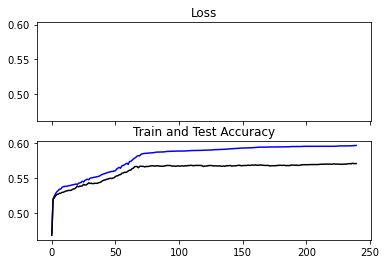

In [27]:
fig, ((ax1),(ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
        
# ax1.plot(range(n_epochs//100), losses)
ax1.title.set_text('Loss') 
        
# accuracy
ax2.plot(train_acc, 'b-', label='train accuracy')
ax2.plot(test_acc, 'k-', label='test accuracy')
ax2.title.set_text('Train and Test Accuracy')
plt.show() 

# Model validation

In [28]:
#Load model
W1 = pd.read_csv('W1_matrix.csv',header=None).values
W2 = pd.read_csv('W2_matrix.csv',header=None).values
b1 = pd.read_csv('b1_vector.csv',header=None).values
b2 = pd.read_csv('b2_vector.csv',header=None).values

In [29]:
W1.shape

(12288, 5)

In [30]:
b1

array([[0.09992941],
       [0.1003964 ],
       [0.10005996],
       [0.0998529 ],
       [0.09993495]])

In [31]:
def Z_function(X_test,W,b):
    val_predict = np.dot(np.array(X_test),W)
    new_val_predict = np.zeros(shape=(val_predict.shape))
    for i in range(len(val_predict)):
        for j in range(len(b)):
            new_val_predict[i] = [val_predict[i][j]+b[j] for j in range(len(b))]
    return new_val_predict    

In [32]:
z1 = Z_function(X_test,W1,b1)
#LeakyRelu
a1 = np.where(z1 > 0, z1, z1 * 0.01)
# Relu
a_relu = np.maximum(0, z1)

In [33]:
z1.shape, a1.shape

((2387, 5), (2387, 5))

In [34]:
z1[0]

array([-485.16626698, -683.16955633, 1230.55196917, -254.74889505,
        853.69844944])

In [35]:
#LeakyRelu
a1[0]

array([  -4.85166267,   -6.83169556, 1230.55196917,   -2.54748895,
        853.69844944])

In [36]:
#Relu
a_relu[0]

array([   0.        ,    0.        , 1230.55196917,    0.        ,
        853.69844944])

In [37]:
z2 = Z_function(a_relu,W2,b2)

In [38]:
z2.shape

(2387, 2)

In [39]:
z2[0]

array([-188.55547915,  -73.16680937])

In [40]:
valudate_prediction = predictor(z2)

In [41]:
valudate_prediction[0]

1

In [42]:
metrics_classific(y_test,valudate_prediction, X_test)
print("LogLoss :", log_loss(y_test,sigmoid(z2)))

[[ 301  767]
 [ 213 1106]]
              precision    recall  f1-score   support

         0.0       0.59      0.28      0.38      1068
         1.0       0.59      0.84      0.69      1319

    accuracy                           0.59      2387
   macro avg       0.59      0.56      0.54      2387
weighted avg       0.59      0.59      0.55      2387

Validation ROC-AUC score: 0.5601746158848067
Validation AUC score:     0.5601746158848067
Accuracy: 58.94%
LogLoss : 2.712948309096176


In [43]:
z1 = Z_function(X_validate,W1,b1)
a1 = np.where(z1 > 0, z1, z1 * 0.01) #LeakyRelu
#a1 = np.maximum(0, z1) #Relu
z2 = Z_function(a1,W2,b2)

In [44]:
metrics_classific(y_validate,predictor(z2), X_validate)
print("LogLoss :", log_loss(y_validate,sigmoid(z2)))

[[162 373]
 [ 98 544]]
              precision    recall  f1-score   support

         0.0       0.62      0.30      0.41       535
         1.0       0.59      0.85      0.70       642

    accuracy                           0.60      1177
   macro avg       0.61      0.58      0.55      1177
weighted avg       0.61      0.60      0.57      1177

Validation ROC-AUC score: 0.5750778816199378
Validation AUC score:     0.5750778816199378
Accuracy: 59.98%
LogLoss : 2.929621206215363
